# Citation count training

In [1]:
from __future__ import print_function
import numpy as np
import keras
import os
from pandas import read_csv

import subprocess
import platform
import datetime as dt
import pickle, joblib

from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras.layers.core import Dense, Activation
from keras.layers import PReLU
from keras.models import Sequential
from keras.utils import np_utils
from keras import regularizers, optimizers
import keras.backend as K
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1)

Using TensorFlow backend.


In [2]:
# Reproducibility code

# save python environment when run
open('Keras_citations_text_training_environment-2-17-20.txt', 'wb').write(subprocess.check_output(['pip', 'list']))

# underlying platform
system = platform.uname()

# python version
python_version = platform.python_version()

# date and time of run
date = dt.datetime.today().strftime("%Y-%m-%d %H:%M:%S")

config = {
    'system': system,
    'python_version': python_version,
    'date': date
}

pickle.dump(config, open('Keras_citations_text_training_config-2-17-20.p', 'wb'))

In [3]:
# Using AMD gpu with PlaidML and Metal
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [4]:
# Create our data function

def data(indep_variables, target):
    """
    Importing data, dropping id variables, scaling data between 0 and 1 for benefit of activation functions
    """
    indep_variables = read_csv(indep_variables, header = 0)
    target = read_csv(target, header = 0)
    train_x, test_x, train_y, test_y= train_test_split(indep_variables, target, test_size = 0.05, random_state = 1)
    x_scaler = MinMaxScaler().fit(train_x)
    train_x = x_scaler.transform(train_x)
    test_x = x_scaler.transform(test_x)
    joblib.dump(x_scaler, "Citations_text_cosine_similarity_training_MinMaxScaler-2-17-20.save")
    return train_x, train_y, test_x, test_y

In [5]:
# Load the data
indep_variables = '../Patent_text_independent_variables-11-13-19.csv'
target = '../Citation_count_y-11-13-19.csv'

train_x, train_y, test_x, test_y = data(indep_variables, target)

In [6]:
"""
Instantiate a model - the architectural choices chosen by Hyperas
led to erratic loss during training, these are slightly different

The loss function is MSE, which is more appropriate for a 
logarithmic dependent variable and robust to outliers
""" 

model = Sequential() 
model.add(Dense(31, input_shape=(31,), kernel_initializer='he_normal'))
model.add(keras.layers.PReLU())
model.add(Dense(26, kernel_initializer='he_normal'))
model.add(keras.layers.PReLU())
model.add(Dense(24, kernel_initializer='he_normal'))
model.add(keras.layers.PReLU())    
model.add(Dense(20, kernel_initializer='he_normal'))
model.add(keras.layers.PReLU())
model.add(Dense(18, kernel_initializer='he_normal'))
model.add(keras.layers.PReLU())
model.add(Dense(14, kernel_initializer='he_normal'))
model.add(keras.layers.PReLU())
model.add(Dense(6, kernel_initializer='he_normal'))
model.add(keras.layers.PReLU())
model.add(Dense(8, kernel_initializer='he_normal'))
model.add(keras.layers.PReLU())
model.add(Dense(1, kernel_initializer='he_normal'))
    
model.compile(loss='mean_squared_error', metrics=['mae'], optimizer='adam')

In [7]:
# Create our callbacks and train

callbacks = [EarlyStopping(monitor='val_loss',
                           patience=3,
                           verbose=1,
                           mode='min',
                           restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=2,
                               verbose=1,
                               mode='auto',
                               min_lr=1e-5),
             ModelCheckpoint("citations_text_model_epoch_no.{epoch:03d}-2-17-20.h5",
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='min',
                             period=1),
             CSVLogger('citations_text_training-2-17-20.log')]
    
result = model.fit(train_x,
                   train_y,
                   batch_size=16,
                   epochs=30,
                   verbose=1,
                   callbacks=callbacks,
                   validation_split=0.05)




Train on 4507301 samples, validate on 237227 samples
Epoch 1/30





4507301/4507301 [==============================] - 1068s 237us/step - loss: 0.9139 - mean_absolute_error: 0.7602 - val_loss: 0.8733 - val_mean_absolute_error: 0.7378

Epoch 00001: val_loss improved from inf to 0.87333, saving model to citations_text_model_epoch_no.001-2-17-20.h5
Epoch 2/30
4507301/4507301 [==============================] - 1229s 273us/step - loss: 0.8554 - mean_absolute_error: 0.7293 - val_loss: 0.8437 - val_mean_absolute_error: 0.7243

Epoch 00002: val_loss improved from 0.87333 to 0.84367, saving model to citations_text_model_epoch_no.002-2-17-20.h5
Epoch 3/30
4507301/4507301 [==============================] - 1278s 283us/step - loss: 0.8433 - mean_absolute_error: 0.7223 - val_loss: 0.8492 - val_mean_absolute_error: 0.7225

Epoch 00003: val_loss did not improve from 0.84367
Epoch 4/30
4507301/4507301 [==============================] - 1269s 281us/step - loss: 0.8378 - mean_absolute_error: 0.7186 

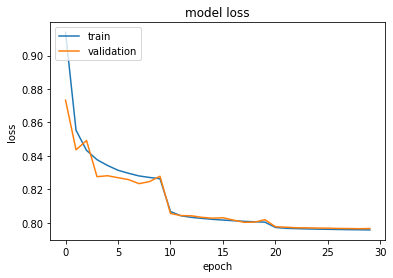

In [8]:
# Loss plot
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

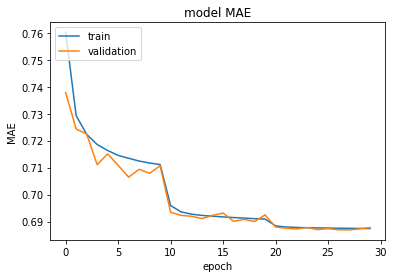

In [9]:
# MAE plot
plt.plot(result.history['mean_absolute_error'])
plt.plot(result.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

As with the training for patent counts, this training was erratic and also started overfitting very quickly. The width and depth of the layers that hyperas chose worked well but the adaptive optimizer could not handle the data and a learning rate reduction schedule was necessary. In retrospect, I may have used a learning rate range test to find a good learning rate.

In [10]:
from keras.models import load_model
model1 = load_model('citations_text_model_epoch_no.029-2-17-20.h5')
print(model1.evaluate(test_x, test_y))

249713/249713 [==============================] - 8s 33us/step
[0.7974384146170007, 0.6879178053164676]


The loss and MAE of this epoch of training are 0.79 and 0.68, respectively, much higher than those for the patent count training but most of the patents had at least a couple of citations. Since the margin of error is around 2 patents (these are logs), pay attention to these results if they start predicting 3 or more citations for a patent based on the description text simiarity with the patents of peer companies--that indicates quality, which leads to value.